In [1]:
import torch
import importlib
import callback, my_attn, my_pipeline
importlib.reload(callback)
importlib.reload(my_attn)
importlib.reload(my_pipeline)
from my_pipeline import run_with_attn_replacement
from diffusers import StableDiffusionPipeline, DDIMInverseScheduler, DDIMScheduler
from my_attn import prep_unet_attention
from tqdm.notebook import tqdm
from callback import QKVRecordCallback
from utils import load_image, img_to_latents, concat_img 
from callback import ATTN_BLOCKS
from PIL import Image
import matplotlib.pyplot as plt

2024-06-07 04:25:54.256465: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 04:25:54.297898: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 04:25:54.297981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 04:25:54.299159: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-07 04:25:54.306362: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 04:25:54.306967: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
device = 'cuda'
dtype = torch.float16
model_dir = '/home/tom/fshare/models/Stability-AI/stable-diffusion-2-1'
# model_dir = '/home/tom/fshare/models/runwayml/stable-diffusion-v1-5'

pipe = StableDiffusionPipeline.from_pretrained(
    model_dir, safety_checker=None, torch_dtype=dtype)

pipe = pipe.to(device)
negative_prompt = "longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality"

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
def get_callback_from_inversion(
    img_dir: str,
    attn_index: list[int],
    record_per_step: int,
    p: StableDiffusionPipeline,
    prompt: str
) -> tuple[QKVRecordCallback, torch.Tensor]:
    r"""
    Args:
        img_dir (str): The directory of the image to invert.
        attn_index (list[int]): The index of the attention blocks to record. 
            Recording too many blocks will result in CUDA out of memory.
        record_per_step (int): The number of records per step. If num_inference_steps is 1000, 
            and record_per_step is 10, then 100 records will be recorded.
        p (StableDiffusionPipeline): The pipeline to use.
        prompt (str): The prompt to use.
    """
    prep_unet_attention(p.unet)
    input_img = load_image(
        img_dir,
        target_size=(512, 512)
    ).to(device=device, dtype=dtype)

    with torch.no_grad():
        inverse_callback = QKVRecordCallback(
            p,
            attn_index=attn_index,
            record_per_step=record_per_step,
            start=0,
            end=1000,
            name='inverse',
            inverse=True
        )
        p.scheduler = DDIMInverseScheduler.from_pretrained(
            model_dir, subfolder='scheduler')
        latents = img_to_latents(input_img, p.vae)  # VAE latent
        inv_latents, _ = p(
            prompt=prompt,
            guidance_scale=1,
            width=input_img.shape[-1],
            height=input_img.shape[-2],
            output_type='latent',
            return_dict=False,
            num_inference_steps=999,
            latents=latents,
            callback_on_step_end=inverse_callback
        )
    return inverse_callback, inv_latents

To record all cross attention blocks for attn_map replacing, set `attn_index=list(range(1, 32, 2))`.

In [4]:
Image.open('kitten.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'kitten.jpg'

In [4]:
prompt = 'A kitten is sitting in a basket on a branch'
inv_callback, latent = get_callback_from_inversion('kitten.jpg', list(range(1, 32, 2)), 25,  pipe, "an anime girl with background")

The config attributes {'skip_prk_steps': True} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/999 [00:00<?, ?it/s]

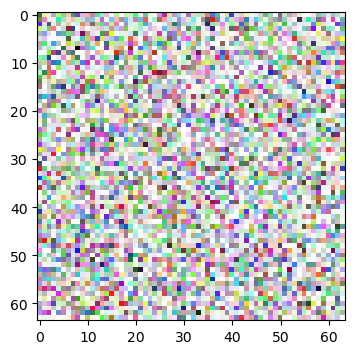

In [89]:
plt.figure(figsize=(4, 4))
plt.imshow(concat_img([latent]))

  0%|          | 0/40 [00:00<?, ?it/s]

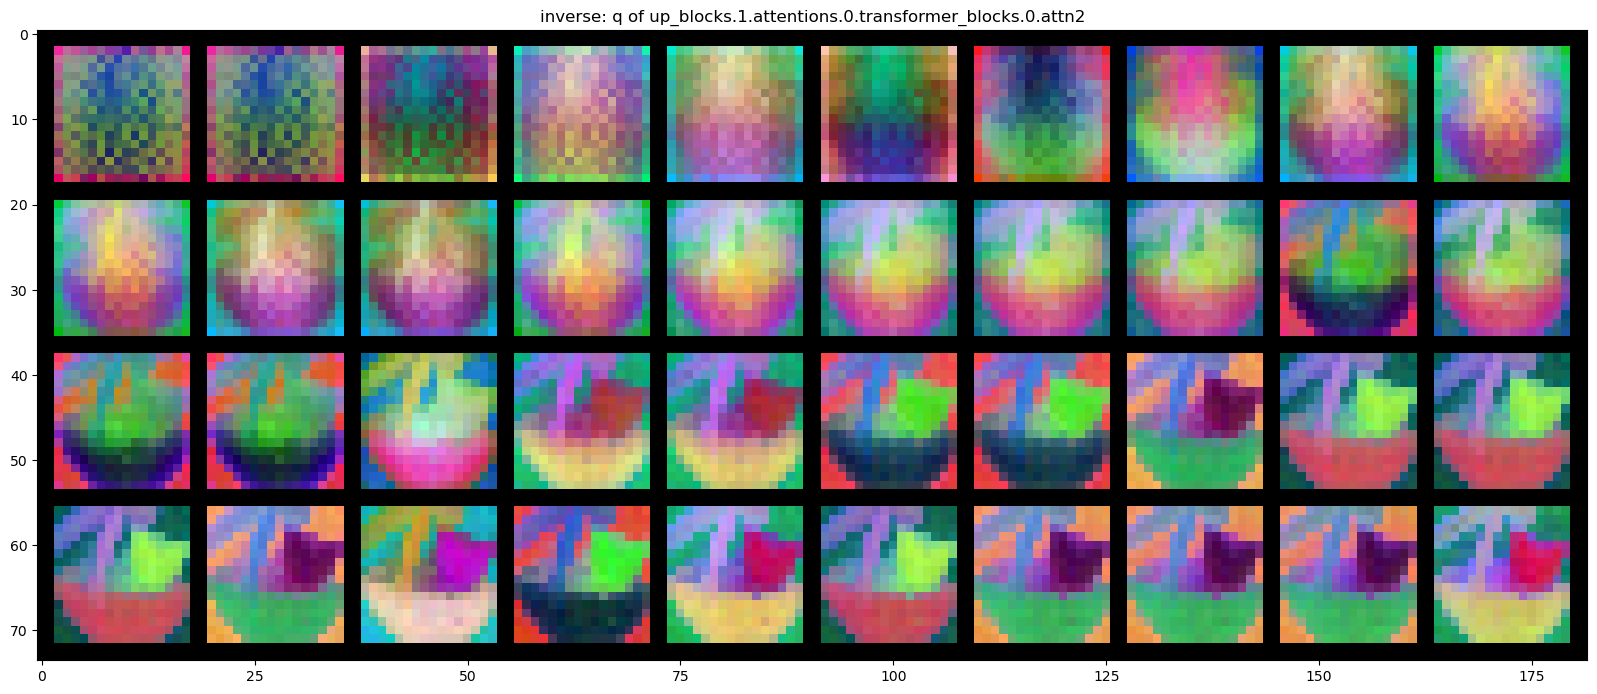

In [5]:
# inv_callback_atri.attn_map_visualization(attn_id=13, pos=1, temperature=1, prompt=prompt, chunk=1)
inv_callback.qkv_visualization(attn_id=13, qkv='q')

  0%|          | 0/40 [00:00<?, ?it/s]

['a</w>', 'kitten</w>', 'is</w>', 'sitting</w>', 'in</w>', 'a</w>', 'basket</w>', 'on</w>', 'a</w>', 'branch</w>']


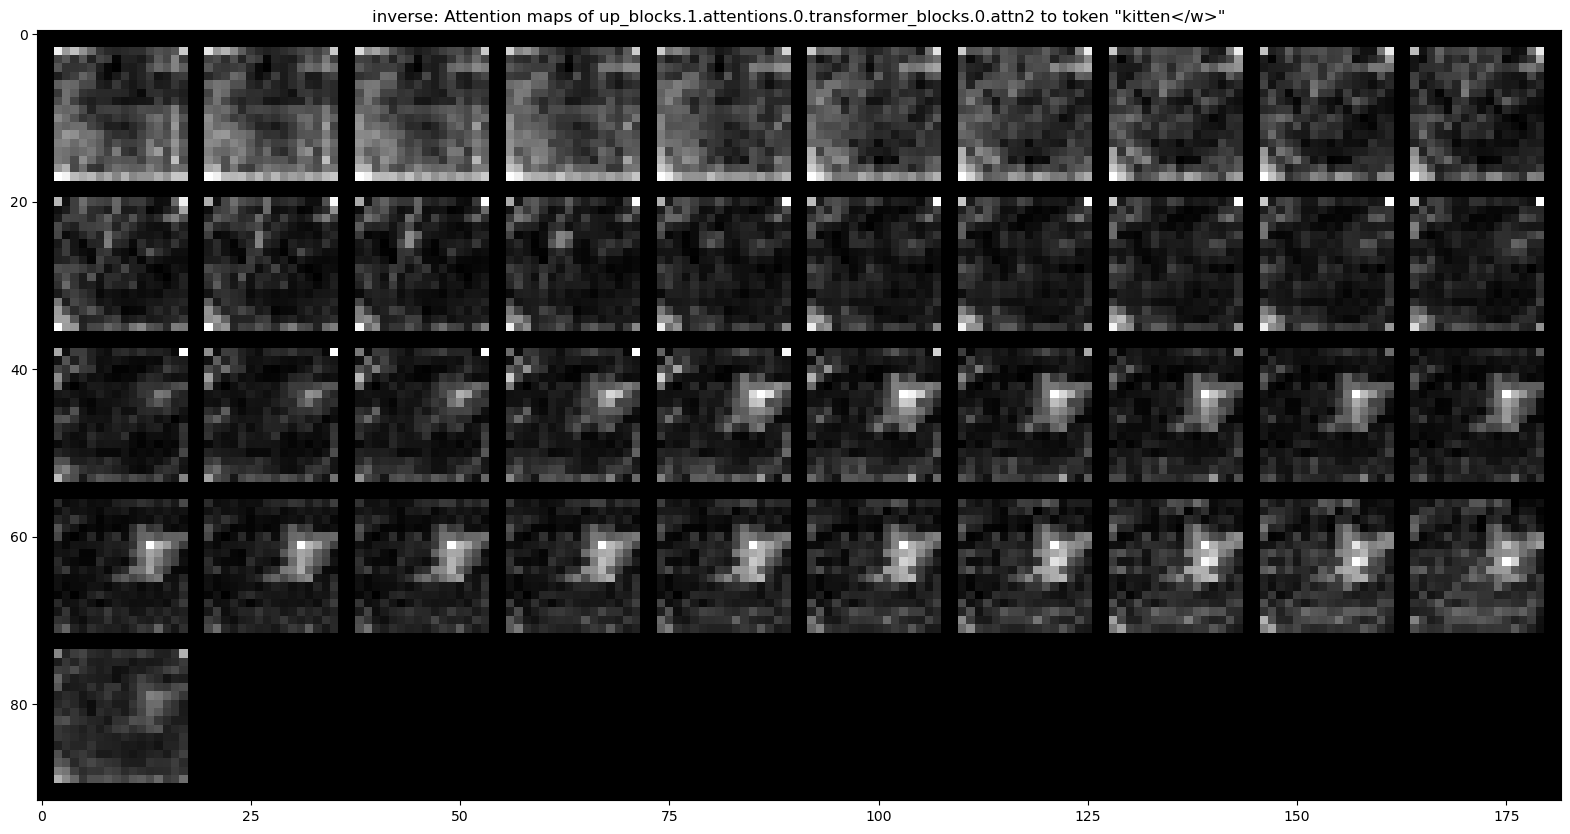

In [15]:
inv_callback.attn_map_visualization(attn_id=13, pos=1, temperature=1, prompt=prompt, chunk=1)

#### Inference without attn replacement

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

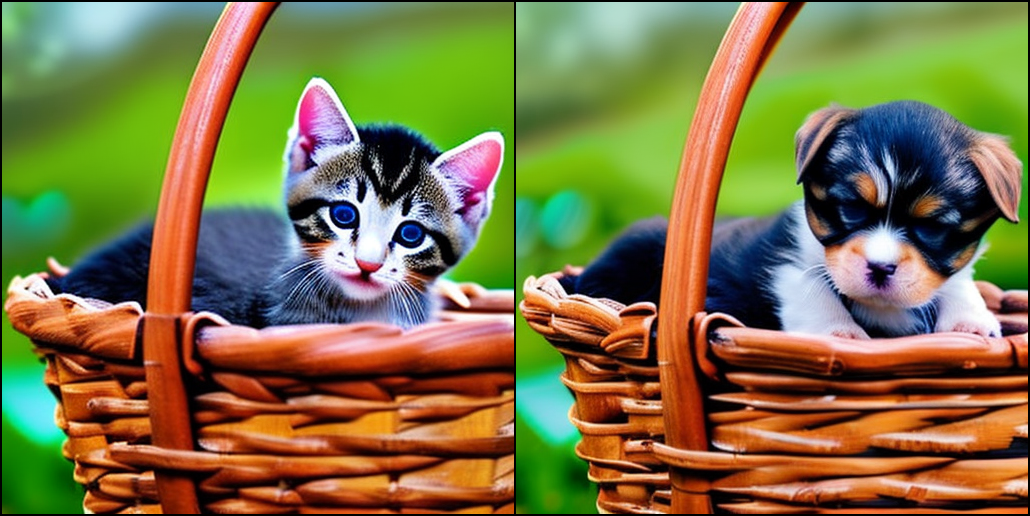

In [59]:
pipe.scheduler = DDIMScheduler.from_pretrained(
    model_dir, subfolder='scheduler')
image_0 = run_with_attn_replacement(  # original image settings
    p=pipe,
    prompt=prompt,
    timesteps=torch.stack(inv_callback.timesteps),
    guidance_scale=7.5,
    latents=latent,
)[0]
image_1 = run_with_attn_replacement(
    p=pipe,
    prompt=prompt.replace('kitten', 'puppy'),
    timesteps=torch.stack(inv_callback.timesteps),
    guidance_scale=7.5,
    latents=latent,
)[0]
concat_img([image_0.unsqueeze(0), image_1.unsqueeze(0)])

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

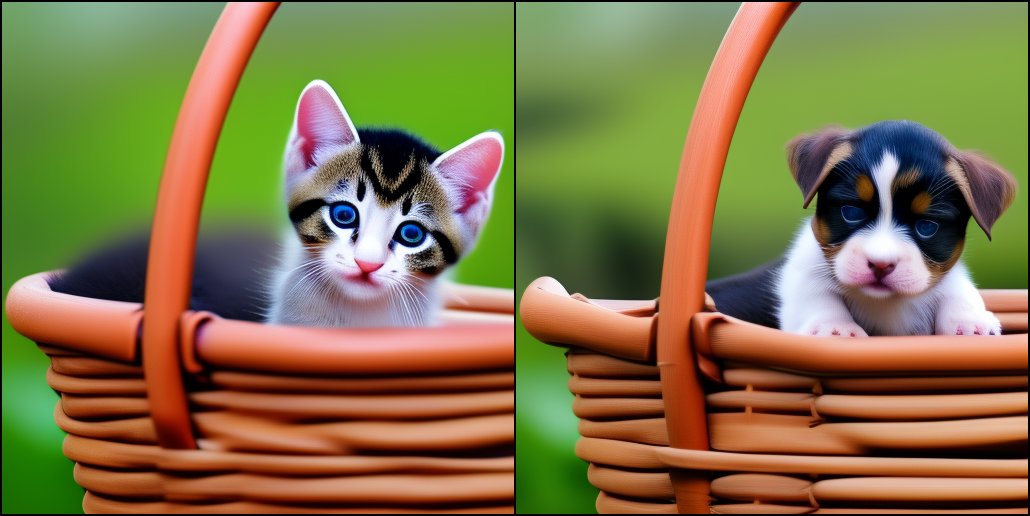

In [83]:
w = 0.9
latent_with_noise = w * latent + torch.randn_like(latent) * (1 - w)
pipe.scheduler = DDIMScheduler.from_pretrained(
    model_dir, subfolder='scheduler')
image_0 = run_with_attn_replacement(  # original image settings
    p=pipe,
    prompt=prompt,
    timesteps=torch.stack(inv_callback.timesteps),
    guidance_scale=7.5,
    latents=latent_with_noise,
)[0]
image_1 = run_with_attn_replacement(
    p=pipe,
    prompt=prompt.replace('kitten', 'puppy'),
    timesteps=torch.stack(inv_callback.timesteps),
    guidance_scale=7.5,
    latents=latent_with_noise,
)[0]
concat_img([image_0.unsqueeze(0), image_1.unsqueeze(0)])

In [75]:
new_latent = torch.randn_like(latent)

#### Run forward process with attn query replaced

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

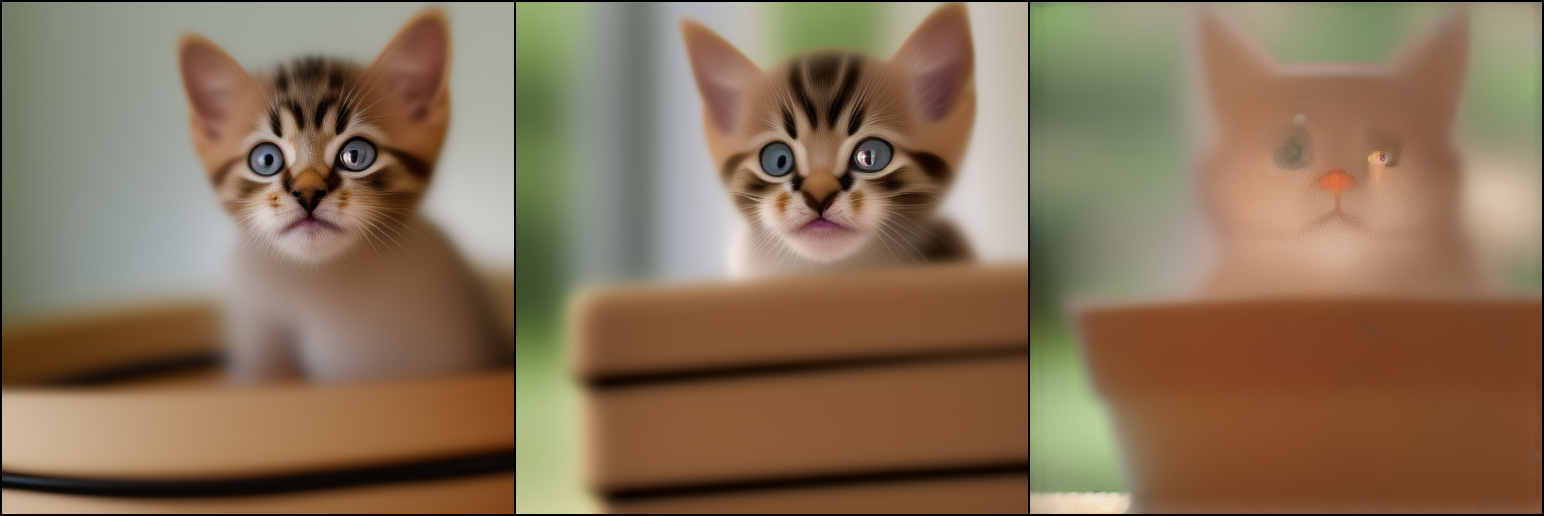

In [96]:
alpha = 0.8
noisy_latent = alpha * new_latent + (1 - alpha) * latent
pipe.scheduler = DDIMScheduler.from_pretrained(
    model_dir, subfolder='scheduler')
inf_callback = QKVRecordCallback(
    pipe,
    attn_index=[1, 2, 12, 13],
    record_per_step=1,
    start=0,
    end=1000,
    name='inverse',
)
image_2 = run_with_attn_replacement(  # new latent, no attention replacement
    p=pipe,
    prompt=prompt,
    timesteps=torch.stack(inv_callback.timesteps),
    guidance_scale=7.5,
    latents=noisy_latent,
)[0]
image_3 = run_with_attn_replacement(
    p=pipe,
    replaced_attn_indice=[11],
    end=301,
    ref_callback=inv_callback,
    prompt=prompt,
    timesteps=torch.stack(inv_callback.timesteps),
    guidance_scale=7.5,
    latents=noisy_latent,
    # callback_on_step_end=inf_callback
)[0]
image_4 = run_with_attn_replacement(
    p=pipe,
    replaced_attn_indice=list(range(1, 32, 2)),
    end=301,
    ref_callback=inv_callback,
    prompt=prompt,
    timesteps=torch.stack(inv_callback.timesteps),
    guidance_scale=7.5,
    latents=noisy_latent,
    # callback_on_step_end=inf_callback
)[0]

concat_img([image_2.unsqueeze(0), image_3.unsqueeze(0), image_4.unsqueeze(0)])